# Introduction

We use 10 fold cross validation to optimize the discretization/number of indicator function states. We look at how each metric performes as we increase the amount of data

## Imports and defaults

In [263]:
from msmbuilder.cluster import NDGrid
from pyemma.msm import BayesianMSM, MaximumLikelihoodMSM

In [264]:
import pyemma.msm as msm
import pyemma.plots as mplt


In [265]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy
import pandas as pd
from numpy import random
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [16]:
sns.set_style('ticks')
sns.set_context('paper')

## Transition matrix and potential

In [17]:
DIFFUSION_CONST = 1e3
DT = 1e-3
DT_SQRT_2D = DT * np.sqrt(2 * DIFFUSION_CONST)

QUADWELL_GRAD_POTENTIAL = lambda x: 4 * (
    8 * x ** 7 - 128 * x * np.exp(-80 * x ** 2) - \
    32 * (x - 0.5) * np.exp(-80 * (x - 0.5) ** 2) - 40 * (x + 0.5) * np.exp(
        -40 * (x + 0.5) ** 2))

In [18]:
def _normalize_eigensystem(u, lv, rv):
    """Normalize the eigenvectors of a reversible Markov state model according
    to our preferred scheme.
    """
    # first normalize the stationary distribution separately
    lv[:, 0] = lv[:, 0] / np.sum(lv[:, 0])

    for i in range(1, lv.shape[1]):
        # the remaining left eigenvectors to satisfy
        # <\phi_i, \phi_i>_{\mu^{-1}} = 1
        lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))

    for i in range(rv.shape[1]):
        # the right eigenvectors to satisfy <\phi_i, \psi_j> = \delta_{ij}
        rv[:, i] = rv[:, i] / np.dot(lv[:, i], rv[:, i])

    return u, lv, rv

In [19]:
def _solve_msm_eigensystem(transmat, k):
    u, lv, rv = scipy.linalg.eig(transmat, left=True, right=True)
    order = np.argsort(-np.real(u))
    u = np.real_if_close(u[order[:k]])
    lv = np.real_if_close(lv[:, order[:k]])
    rv = np.real_if_close(rv[:, order[:k]])
    return _normalize_eigensystem(u, lv, rv)



In [20]:
def brownian_transmat(n_grid, lag_time, grad_potential, xmin, xmax, reflect_bc):
    ONE_OVER_SQRT_2PI = 1.0 / (np.sqrt(2 * np.pi))
    normalpdf = lambda x: ONE_OVER_SQRT_2PI * np.exp(-0.5 * (x * x))

    grid = np.linspace(xmin, xmax, n_grid)
    width = grid[1] - grid[0]
    transmat = np.zeros((n_grid, n_grid))
    for i, x_i in enumerate(grid):
        if reflect_bc:
            for offset in range(-(n_grid - 1), n_grid):
                x_j = x_i + (offset * width)
                j = _reflect_boundary_conditions(i + offset, 0, n_grid - 1)

                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)
        else:
            for j, x_j in enumerate(grid):
                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)

        transmat[i, :] = transmat[i, :] / np.sum(transmat[i, :])
    transmat = np.linalg.matrix_power(transmat, lag_time)
    return transmat

# Simulation

In [21]:
# These are determined from QuadWell Exact Values
tau = 25
t2 = int(844/DT)
xmin, xmax = -1.2, 1.2
N = 500

In [22]:
T = brownian_transmat(n_grid=N, lag_time=tau, grad_potential=QUADWELL_GRAD_POTENTIAL, 
                      xmin=xmin, xmax=xmax, reflect_bc=False)
u, lv, rv =  _solve_msm_eigensystem(T, N)

##  Get starting points from equilibrium distribution

In [23]:
mu = np.real(lv[:, 0])
mu_cum = np.cumsum(mu)
grid = np.linspace(xmin, xmax, N)
n_trajectories = int(1e2)

In [24]:
x0 = [np.searchsorted(mu_cum, i) for i in np.random.random(n_trajectories)]
x0 = [grid[i] for i in x0]

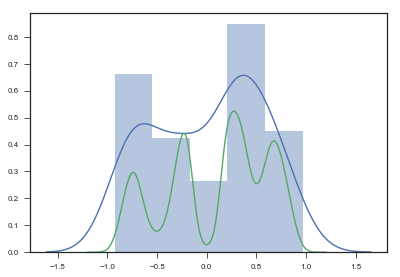

In [25]:
sns.distplot(x0, norm_hist=False)
plt.plot(grid, mu*100)

In [26]:
def _simulate_quadwell(n_steps=1e3, n_trajectories=100, x0=None):
    # DO NOT CHANGE THESE CONSTANTS WITHOUT UPDATING THE
    # "QUADWELL_DESCRIPTION" VARIABLE AND UPDATING THE VERSION NUMBER
    # in the load_quadwell FUNCTION
    if x0 is None:
        x0 = random.uniform(-1, 1, size=n_trajectories)

    trajectories = [_propagate1d(
        x0[i], n_steps, QUADWELL_GRAD_POTENTIAL,
        random=random, verbose=False).reshape(-1, 1)
                    for i in range(n_trajectories)]
    return trajectories

In [27]:
def _propagate1d(x0, n_steps, grad_potential, random, bc_min=None, bc_max=None,
                 verbose=True):
    start = time.time()
    n_steps = int(n_steps)
    if bc_min is None and bc_max is None:
        bc = lambda x: x
    else:
        bc = lambda x: _reflect_boundary_conditions(x, bc_min, bc_max)

    rand = random.randn(n_steps)
    x = np.zeros(n_steps + 1)
    x[0] = x0
    for i in range(n_steps):
        x_i_plus_1 = x[i] - DT * grad_potential(x[i]) + DT_SQRT_2D * rand[i]
        x[i + 1] = bc(x_i_plus_1)

    if verbose:
        print('%d steps/s' % (n_steps / (time.time() - start)))
    return x

## Get trajectories

In [28]:
T = 10*t2
trajectories = _simulate_quadwell(n_steps=T/n_trajectories, n_trajectories=n_trajectories, x0=x0)


In [260]:
_ = [np.save('data/quad_well_{:02d}.npy'.format(i), traj) for i, traj in enumerate(trajectories)]

## Test decorrelation time

In [96]:
def acf(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    x = x[:,0]
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result



In [97]:
C_rrs = [acf(traj[:5000]) for traj in trajectories]

In [98]:
C_rrs = [C_rr[:, np.newaxis] for C_rr in C_rrs]
C_rr = np.concatenate(C_rrs, axis=1)
C_rr = np.mean(C_rr, axis=1)

(-1, 1)

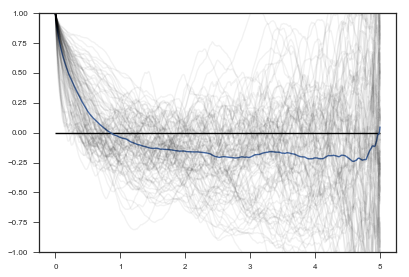

In [150]:
idx = np.arange(C_rr.shape[0])*DT
k = -1
plt.plot(idx[:k], C_rr[:k])
plt.hlines(0, idx[k], 0)
for y in C_rrs:
    plt.plot(idx[:k], y[:k], c='k', alpha=0.05)
plt.ylim((-1,1))

## Check implied timescales vs lag

In [194]:
steps_per_traj = trajectories[0].shape[0]
frac_traj = 5e-3
stride = 1
n_steps = int(frac_traj*steps_per_traj)
trajs = [traj[:n_steps:stride] for traj in trajectories]
print('Number of steps per trajectory {}'.format(n_steps))
print('Number of frames per trajectory {}'.format(int(n_steps/stride)))
print('Total length of trajectories {}/t2'.format(frac_traj*T/t2))

Number of steps per trajectory 422
Number of frames per trajectory 422
Total length of trajectories 0.05/t2


In [195]:
np.sqrt(422*100)

205.42638584174136

In [196]:
cluster = NDGrid(n_bins_per_feature=200, min=xmin, max=xmax)

In [197]:
ctrajs = cluster.fit_transform(trajs)

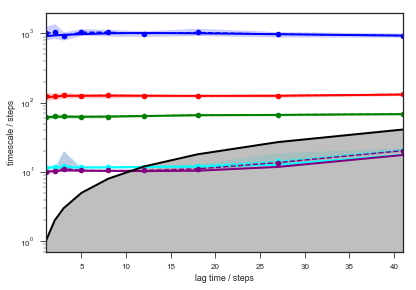

In [201]:
its = msm.timescales_msm(ctrajs, lags=50, nits=5, errors='bayes')
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)


## Get minimum number of MCMC steps

In [183]:
model = BayesianMSM(lag=tau, nsamples=100)
model.fit(ctrajs)
t2_samples = model.sample_f('timescales', k=1)

In [184]:
model = BayesianMSM(lag=tau, nsamples=500)
model.fit(ctrajs)
t2_samples_500 = model.sample_f('timescales', k=1)

In [211]:
model = BayesianMSM(lag=tau, nsamples=1000)
model.fit(ctrajs)
t2_samples_1000 = model.sample_f('timescales', k=1)

In [213]:
# t2_samples = [x[0] for x in t2_samples]
# t2_samples_500 = [x[0] for x in t2_samples_500]
t2_samples_1000 = [x[0] for x in t2_samples_1000]

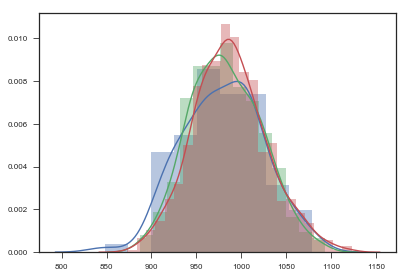

In [214]:
sns.distplot(t2_samples)
sns.distplot(t2_samples_500)
sns.distplot(t2_samples_1000)

In [215]:
print('100 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples), 200*np.std(t2_samples)/np.mean(t2_samples)))
print('500 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples_500), 200*np.std(t2_samples_500)/np.mean(t2_samples_500)))
print('1000 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples_1000), 200*np.std(t2_samples_1000)/np.mean(t2_samples_1000)))

100 samples  979 +/-  9.0%
500 samples  983 +/-  8.1%
1000 samples  987 +/-  8.3%


## Check difference in T matrix counting methods
These should all be the same for Brownian motion

In [216]:
count_methods = ['sliding', 'effective', 'sample']
for method in count_methods:
    model = BayesianMSM(lag=tau, nsamples=500, count_mode=method)
    model.fit(ctrajs)
    mean = model.sample_mean('timescales', k=1)
    std = model.sample_std('timescales', k=1)
    print('{2} : mean {0:4.2f} +/- {1:4.2f} %'.format(mean[0], 200*std[0]/mean[0], method))
    

sliding : mean 996.52 +/- 8.18 %
effective : mean 986.19 +/- 8.48 %
sample : mean 1253.30 +/- 41.14 %


## ML vs Bayesian Timescales

In [218]:
ml = MaximumLikelihoodMSM(lag=tau)
bayes = BayesianMSM(lag=tau, nsamples=500)
ml.fit(ctrajs)
bayes.fit(ctrajs)

BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=25, nsamples=500, nsteps=13, reversible=True,
      show_progress=True, sparse=False, statdist_constraint=None)

In [220]:
n_ts = 10
ml_ts = ml.timescales(k=n_ts)
bayes_ts = bayes.timescales(k=n_ts)

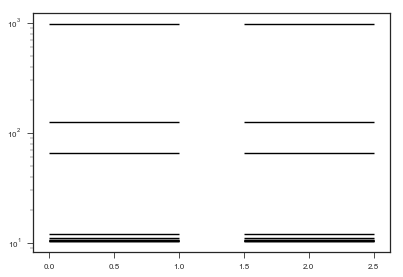

In [225]:
for i in range(n_ts):
    plt.hlines( ml_ts[i], 0,1)
    plt.hlines( bayes_ts[i], 1.5,2.5)
plt.yscale('log')

In [258]:
for i in range(n_ts):
    print('t {0:<#2}: ML {1:#6.2f} Bayes {2:#6.2f} Diff {3:#6.2f}%'.format(i+1, ml_ts[i], bayes_ts[i], 
                                                                          100*(ml_ts[i]/bayes_ts[i]-1)))

t 1 : ML 979.26 Bayes 978.14 Diff   0.11%
t 2 : ML 125.68 Bayes 125.69 Diff  -0.00%
t 3 : ML  66.23 Bayes  66.22 Diff   0.02%
t 4 : ML  12.10 Bayes  12.10 Diff  -0.03%
t 5 : ML  11.04 Bayes  11.05 Diff  -0.09%
t 6 : ML  10.64 Bayes  10.64 Diff  -0.02%
t 7 : ML  10.58 Bayes  10.58 Diff  -0.05%
t 8 : ML  10.46 Bayes  10.49 Diff  -0.23%
t 9 : ML  10.44 Bayes  10.45 Diff  -0.01%
t 10: ML  10.32 Bayes  10.36 Diff  -0.38%


## Make HMM

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/ipykernel/__main__.py:3: PyEMMA_DeprecationWarning: The dtrajs argument will be mandatory in the future for method hmm.
  app.launch_new_instance()


In [210]:
hmm

MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
           lag=25, maxit=1000, mincount_connectivity=0.25,
           msm_init=BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=25, nsamples=100, nsteps=13, reversible=True,
      show_progress=True, sparse=False, statdist_constraint=None),
           nstates=4, observe_nonempty=True, reversible=True,
           separate=None, stationary=False, stride=1)

## Pipeline to optimize 

In [ ]:
steps_per_traj = trajectories[0].shape[0]
frac_traj = 1e-1
stride = 100
n_steps = int(frac_traj*steps_per_traj)
trajs = [traj[:n_steps:stride] for traj in trajectories]
print('Number of steps per trajectory {}'.format(n_steps))
print('Number of frames per trajectory {}'.format(int(n_steps/stride)))
print('Total length of trajectories {}/t2'.format(frac_traj*T/t2))

In [6]:
data = np.random.choice(np.arange(5), 50)
print(data)
pipeline = Pipeline([
    ('msm', MaximumLikelihoodMSM(lag=5, score_method='vamp2', score_k=4)),
])
pipeline.fit(data)

[3 1 4 2 2 0 0 2 0 1 0 3 2 1 0 1 1 3 2 2 4 4 0 3 4 0 4 3 1 4 2 4 1 4 1 1 2
 2 2 3 1 1 0 0 1 3 4 2 3 1]


TypeError: fit() takes 2 positional arguments but 3 were given

In [9]:
data = np.random.choice(np.arange(5), 50)
model =  MaximumLikelihoodMSM(lag=5, score_method='vamp2', score_k=2)
model.fit(data)
print('score_k = {}'.format(model.score_k))
model.score(data)
print('score_k = {}'.format(model.score_k))

score_k = 2
score_k = 5


In [ ]:
pipeline = Pipeline([
    ('grid', NDGrid(min=-1.2, max=1.2)),
    ('msm', MaximumLikelihoodMSM(lag=tau, score_method='vamp2', score_k=4)),
])

In [ ]:
search = GridSearchCV(pipeline, cv=5, refit=False, 
                      param_grid={'grid__n_bins_per_feature': list(np.arange(5, 105, 10))})

In [ ]:
search.fit(trajs)

In [ ]:
df = pd.DataFrame(search.cv_results_)

In [ ]:
df.head()

In [ ]:
plt.errorbar(df['param_grid__n_bins_per_feature'], df['mean_test_score'],yerr=df['std_test_score'], label='test')
# plt.errorbar(df['param_grid__n_bins_per_feature'], df['mean_train_score'],yerr=df['std_train_score'], label='train')
plt.legend()
# plt.ylim((1.55,1.585))
# plt.yscale('log')